# Oracle-Reto 2: Análisis de sentimiento

*NUWE EVA*, la cadena de restauración fast food y healthy, sigue creciendo y queremos dar un paso más para mejorar y ofrecer el mejor servicio posible a nuestros clientes.

Queremos evolucionar y ofrecer nuevas capacidades a nuestro robot y talentoso camarero, *EVA*, añadiendo la función de poder detectar, a través de frases y palabras utilizadas por los comensales, el grado de satisfacción de los platos probados y así ver qué platos y productos han gustado más o menos a los clientes.

Nuestro robot ya sabe detectar lo que pedirán los comensales según los productos elegidos. Ahora queremos saber cuál es el feedback de cada cliente para detectar si le ha gustado o no el plato servido.

> Objetivo
Crea un modelo predictivo de **clasificación** para poder **ordenar y o catalogar las reseñas**. Primero entrena tu modelo con las reseñas de entrenamiento. Una vez tengas el modelo que maximice la puntuación F1 (macro.), utiliza las reseñas de prueba como entrada para tu modelo.

In [1]:
from numpy import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../Data/train.csv',index_col = [0])
test = pd.read_csv('../Data/test.csv',index_col = [0])

In [3]:
train.head()

,text,label,label_text
train_idx,,,
0,i really do recommend this to anyone in need o...,1,positive
1,very good every day camera fits nicely in the ...,1,positive
2,"but , dollar for dollar , this dvd player is p...",1,positive
3,i got this phone yesterday and didn ' t find a...,1,positive
4,1 ) price gb of storage,1,positive


In [4]:
test.head()

,text
test_idx,
0,fm receiver it has none
1,"the picture quality surprised me , when i firs..."
2,great video clip quality for a digital camera ...
3,creative did well on its rechargeable battery ...
4,i highly recommend this camera to anyone looki...


In [5]:
''' shape '''
print(f'shape de los datos train {train.shape}')
print(f'shape de los datos test {test.shape}')

shape de los datos train (3016, 3)
shape de los datos test (754, 1)


In [6]:
train.label.value_counts()

1    1926
0    1090
Name: label, dtype: int64

In [7]:
# eliminamos 'label_text' porque contiene la misma información que 'label'
train.drop(['label_text'], axis=1, inplace=True)

Utilizaremos *stopwords* para eliminar los pronombres y conjunciones presentes en las *reviews*, debido a que no aportan en su mayoría información alguna.

In [8]:
import nltk as nlp
from nltk.corpus import stopwords
# Obtain list of stopwords
stop_words = list(stopwords.words('english'))
print(f'ejemplos de stopwords: {stop_words[:10]}')

ejemplos de stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [9]:
# Spacy Lemmatize
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

Xtrain = train.copy()
Xtest = test.copy()

2023-04-12 11:32:36.419826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Realizamos una limpieza de los datos previo a lematizarlos

In [10]:
import re

# Pasamos a minúscula
Xtrain['text'] = Xtrain['text'].apply(lambda x: x.lower() )
Xtest['text'] = Xtest['text'].apply(lambda x: x.lower() )
# Eliminación de signos de puntuación
regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
Xtrain['text'] = Xtrain['text'].apply(lambda x: re.sub(regex , ' ', x) )
Xtest['text'] = Xtest['text'].apply(lambda x: re.sub(regex , ' ', x) )
# Eliminación de números
Xtrain['text'] = Xtrain['text'].apply(lambda x: re.sub("\d+", ' ', x) )
Xtest['text'] = Xtest['text'].apply(lambda x: re.sub("\d+", ' ', x) )
# Eliminación de espacios en blanco múltiples
Xtrain['text'] = Xtrain['text'].apply(lambda x: re.sub("\\s+", ' ', x) )
Xtest['text'] = Xtest['text'].apply(lambda x: re.sub("\\s+", ' ', x) )

In [11]:
Xtrain['text']

train_idx
0       i really do recommend this to anyone in need o...
1       very good every day camera fits nicely in the ...
2       but dollar for dollar this dvd player is proba...
3       i got this phone yesterday and didn t find any...
4                                     price gb of storage
                              ...                        
3011    as for itunes i don t find it to be as good as...
3012    i have not played with all the features yet bu...
3013    applications it has lots of applications and t...
3014                                    battery non issue
3015    the fm tuner the g of storage and the removabl...
Name: text, Length: 3016, dtype: object

Los convertimos a formato `spacy`

In [12]:
Xtrain['texto'] = Xtrain['text'].apply( lambda x : nlp(x))
Xtest['texto'] = Xtest['text'].apply( lambda x : nlp(x))

In [13]:
Xtrain[['text','texto']]

,text,texto
train_idx,,
0,i really do recommend this to anyone in need o...,"(i, really, do, recommend, this, to, anyone, i..."
1,very good every day camera fits nicely in the ...,"(very, good, every, day, camera, fits, nicely,..."
2,but dollar for dollar this dvd player is proba...,"(but, dollar, for, dollar, this, dvd, player, ..."
3,i got this phone yesterday and didn t find any...,"(i, got, this, phone, yesterday, and, didn, t,..."
4,price gb of storage,"( , price, gb, of, storage)"
...,...,...
3011,as for itunes i don t find it to be as good as...,"(as, for, itunes, i, don, t, find, it, to, be,..."
3012,i have not played with all the features yet bu...,"(i, have, not, played, with, all, the, feature..."
3013,applications it has lots of applications and t...,"(applications, it, has, lots, of, applications..."


Lematizamos

In [14]:
# Mark them as stop words
for w in stop_words:
    nlp.vocab[w].is_stop = True

# Convert each row into spacy document and return the lemma of the tokens in
# the document if it is not a sotp word. Finally join the lemmas into as a string
Xtrain['texto'] = Xtrain['texto'].apply( lambda x : " ".join(token.lemma_ for token in x if not token.is_stop))
Xtest['texto'] = Xtest['texto'].apply( lambda x : " ".join(token.lemma_ for token in x if not token.is_stop))

In [15]:
Xtrain['texto']

train_idx
0                               recommend need new player
1       good day camera fit nicely pocket jean take qu...
2                  dollar dollar dvd player probably good
3                        get phone yesterday find problem
4                                        price gb storage
                              ...                        
3011    itune find good window medium player computer ...
3012                         play feature camera easy use
3013    application lot application work eventually fi...
3014                                    battery non issue
3015      fm tuner g storage removable disk great feature
Name: texto, Length: 3016, dtype: object

In [16]:
Xtrain['label'] = train['label']

In [17]:
Xtrain.head()

,text,label,texto
train_idx,,,
0,i really do recommend this to anyone in need o...,1,recommend need new player
1,very good every day camera fits nicely in the ...,1,good day camera fit nicely pocket jean take qu...
2,but dollar for dollar this dvd player is proba...,1,dollar dollar dvd player probably good
3,i got this phone yesterday and didn t find any...,1,get phone yesterday find problem
4,price gb of storage,1,price gb storage


Una vez tenemos los textos 'depurados', procedemos a hacer un análisis de los mismos

In [18]:
NLP = Xtrain['texto']
# Tokenización por palabras individuales
NLP = NLP.apply(lambda x: x.split(sep = ' '))

In [19]:
NLP = NLP.explode()

In [20]:
# Mean length and std of the reviews
NLP.groupby(['train_idx']).count().describe()

count    3016.000000
mean        7.629642
std         4.690250
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        46.000000
Name: texto, dtype: float64

In [21]:
# borramos el espacio en blanco
NLP = NLP[NLP != '']
# most used words in the reviews
NLP.value_counts(ascending=False)

player          282
use             263
phone           256
camera          255
good            252
               ... 
alkaline          1
rechargeable      1
snugly            1
gremlin           1
handful           1
Name: texto, Length: 3356, dtype: int64

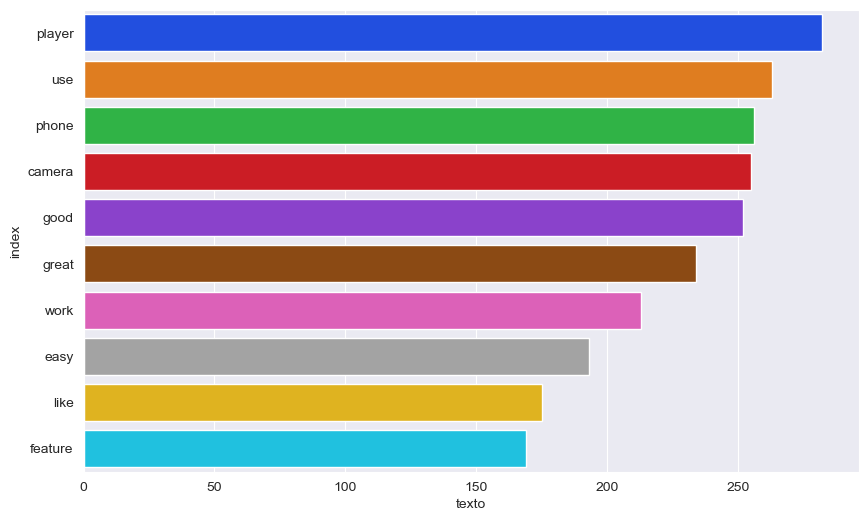

In [22]:
# Top 10 words
plt.figure(figsize=(10, 6))
counts  = NLP.value_counts(ascending=False).reset_index().head(10)
sns.barplot(data = counts, y = 'index', x = 'texto', orient= 'h', palette= 'bright')
plt.show()

In [23]:
Xtrain.to_csv('../Data/New/SpacyTrain.csv')
Xtest.to_csv('../Data/New/SpacyTest.csv')